<a href="https://colab.research.google.com/github/onurerdogan2001/ie423tasks/blob/main/notebooks/task8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

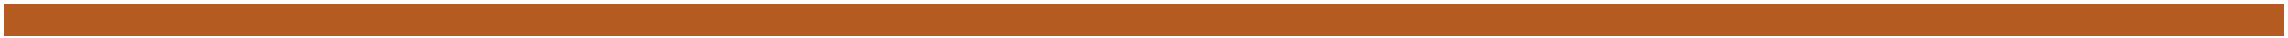

## <font color='#475468'> IE423 TASK8</font>
### <font color='#475468'> Onur Erdoğan 21903313</font>

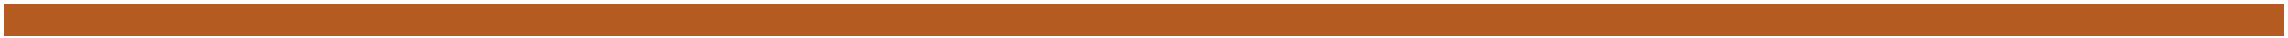

## Initialize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import get_close_matches


## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Joke metadata
dfMvs = pd.read_csv('/content/drive/MyDrive/yazokulu/JokeText.csv')

# User ratings for each joke
dfMvsRtg = pd.read_csv('/content/drive/MyDrive/yazokulu/JokeRatings2.csv')

## Build Recommendations

#### Prepare data

In [4]:
dfMvs.head()

,JokeId,JokeText
0,0,"A man visits the doctor. The doctor says ""I ha..."
1,1,This couple had an excellent relationship goin...
2,2,Q. What's 200 feet long and has 4 teeth? \n\nA...
3,3,Q. What's the difference between a man and a t...
4,4,Q.\tWhat's O. J. Simpson's Internet address? \...


In [5]:
dfMvs.shape

(100, 2)

In [6]:
# Remove duplicates
dfMvs.drop_duplicates(subset ='JokeId', keep = 'first', inplace = True)
dfMvs.shape

(100, 2)

#### Build Model

In [7]:
# Generate a matrix of common terms that show up in each movie

from sklearn.feature_extraction.text import TfidfVectorizer
mdlTfvMvs = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=1, stop_words='english')
tfidf_matrix = mdlTfvMvs.fit_transform(dfMvs['JokeText'])
tfidf_matrix.shape


(100, 3774)

The similarity between any two movies (x) and (y) is defined as the **Cosine Similarity**:
cosine(x,y)=x.y⊺||x||.||y||

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score.

In [8]:
# Calculate cosine similarity between each pair of movies as a function of the similarity of the common terms

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(100, 100)

#### Predict

In [9]:
# Prepare recommendation function (build code from scratch and then package as function for ease of understanding)

JokeTexts = dfMvs['JokeText']
indices = pd.Series(dfMvs.index, index=dfMvs['JokeText'])

def get_recommendations(JokeText, top_n=10):
    # Find jokes containing the keyword
    keyword_jokes = dfMvs[dfMvs['JokeText'].str.contains(JokeText, case=False)]

    if keyword_jokes.empty:
        return f"No jokes containing the word '{JokeText}' found in the dataset."

    # Use the first joke containing the keyword as the closest match
    closest_joke = keyword_jokes['JokeText'].iloc[0]
    idx = indices[closest_joke]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    joke_indices = [i[0] for i in sim_scores]

    recommendations = JokeTexts.iloc[joke_indices]
    return closest_joke, recommendations


In [10]:
# Example usage
example_joke = 'doctor'
result = get_recommendations(example_joke)

if isinstance(result, str):
    print(result)
else:
    closest_joke, recommendations = result
    print(f"Closest joke found: {closest_joke}\n")
    print(recommendations.head(10))


Closest joke found: A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease". 
The man replies "Well,thank God I don't have cancer!"


86    A man, recently completing a routine physical ...
67    A man piloting a hot air balloon discovers he ...
87    A Czechoslovakian man felt his eyesight was gr...
75    There once was a man and a woman that both  go...
31    A man arrives at the gates of heaven. St. Pete...
38    What is the difference between men and women:\...
55    A man and Cindy Crawford get stranded on a des...
80    An Asian man goes into a New York CityBank to ...
32    What do you call an American in the finals of ...
3     Q. What's the difference between a man and a t...
Name: JokeText, dtype: object


In [11]:
# Example usage
example_joke = 'Clown'
result = get_recommendations(example_joke)

if isinstance(result, str):
    print(result)
else:
    closest_joke, recommendations = result
    print(f"Closest joke found: {closest_joke}\n")
    print(recommendations.head(10))


Closest joke found: Two cannibals are eating a clown, one turns to other and says: 
"Does this taste funny to you? 


6     How many feminists does it take to screw in a ...
36    A Jewish young man was seeing a psychiatrist f...
89    Q: How many programmers does it take to change...
16    How many men does it take to screw in a light ...
39    How many Irishmen does it take to change a lig...
57    How many teddybears does it take to change a l...
73    Q: How many stalkers does it take to change a ...
40    What does an atheist say during an orgasm?\n"O...
84    Q: How many Presidents does it take to screw i...
5     Bill & Hillary are on a trip back to Arkansas....
Name: JokeText, dtype: object


utexas_ds_orie_divider_gray.png

### 2. Collaborative Filtering

#### Prepare data

In [12]:
dfMvsRtg.head(10)

,JokeId,User1,User2,User3,User4,User5,User6,User7,User8,User9,...,User36701,User36702,User36703,User36704,User36705,User36706,User36707,User36708,User36709,User36710
0,0,5.10,-8.79,-3.50,7.14,-8.79,9.22,-4.03,3.11,-3.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.91,NaN
1,1,4.90,-0.87,-2.91,-3.88,-0.58,9.37,-1.55,0.92,-3.35,...,NaN,NaN,NaN,-5.63,NaN,-6.07,NaN,-1.60,-4.56,NaN
2,2,1.75,1.99,-2.18,-3.06,-0.58,-3.93,-3.64,7.52,-6.46,...,NaN,NaN,NaN,NaN,NaN,4.08,NaN,NaN,8.98,NaN
3,3,-4.17,-4.61,-0.10,0.05,8.98,9.27,-6.99,0.49,-3.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5.15,5.39,7.52,6.26,7.67,3.45,5.44,-0.58,1.26,...,2.28,-0.49,5.10,-0.29,-3.54,-1.36,7.48,-5.78,0.73,2.62
5,5,1.75,-0.78,1.26,6.65,8.25,-8.11,-6.75,2.14,0.34,...,NaN,-3.40,-0.92,-4.27,NaN,-2.57,9.32,7.96,-9.13,3.30
6,6,4.76,1.60,-5.39,-7.52,4.08,4.42,-0.15,-0.24,-3.01,...,-9.95,-4.42,0.97,-3.54,6.36,3.01,3.74,5.19,-9.42,0.53
7,7,3.30,1.07,1.50,7.28,2.52,2.72,-5.87,8.06,-6.65,...,4.32,-1.07,0.49,-2.14,2.57,-5.73,-2.33,2.67,8.69,-2.62
8,8,-2.57,-8.69,-8.40,-5.15,-9.66,9.08,-3.54,2.82,-3.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,-1.41,-4.66,4.37,-7.14,2.48,9.13,-5.19,7.52,1.36,...,-8.40,-6.26,-1.17,0.44,7.52,8.59,8.88,6.07,8.35,3.06


In [15]:
# Prepare data into Surprise library format

!pip3 install scikit-surprise #or !conda install -c conda-forge scikit-surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

# Transform the wide format data into long format
df_long = pd.melt(dfMvsRtg, id_vars=['JokeId'], var_name='userId', value_name='rating')

# Prepare data into Surprise library format
reader = Reader(rating_scale=(-10, 10))  # Adjust rating scale if needed
data = Dataset.load_from_df(df_long[['userId', 'JokeId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

# Example to check the data
print(df_long.head())

   JokeId userId  rating
0       0  User1    5.10
1       1  User1    4.90
2       2  User1    1.75
3       3  User1   -4.17
4       4  User1    5.15


#### Build Model

In [16]:
reader = Reader(rating_scale=(0,5))
X = Dataset.load_from_df(df_long[['userId', 'JokeId', 'rating']], reader)
X_train, X_test = train_test_split(X, test_size=.25)

In [17]:
# Define SVD model

from surprise import SVD

mdlSvdMvsRtg = SVD()

In [18]:
# Fit SVD model

mdlSvdMvsRtg.fit(X_train)
test_pred = mdlSvdMvsRtg.test(X_test)

In [19]:
# Evalute SVD accuracy

from surprise import accuracy

accuracy.rmse(test_pred)

RMSE: nan


nan

In [20]:
# Check for invalid ratings (outside the range) or NaN values and remove them
df_long = df_long[(df_long['rating'] >= -10) & (df_long['rating'] <= 10)]
df_long.dropna(subset=['rating'], inplace=True)

# Prepare data into Surprise library format
reader = Reader(rating_scale=(-10, 10))  # Adjust rating scale based on your data
data = Dataset.load_from_df(df_long[['userId', 'JokeId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

# Define and train the SVD model
mdlSvdJokesRtg = SVD()
mdlSvdJokesRtg.fit(trainset)

# Generate predictions
test_pred = mdlSvdJokesRtg.test(testset)

# Evaluate RMSE
accuracy.rmse(test_pred)


<ipython-input-20-bea1adecd0d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long.dropna(subset=['rating'], inplace=True)


RMSE: 4.1898


4.189771978065715

In [21]:
# Tune hyperparameters

from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [10, 15], 'lr_all': [0.005],
              'reg_all': [0.4]}


gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=-1)

gs.fit(X)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

nan
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [22]:
# Cross-validate

from surprise.model_selection import cross_validate

cross_validate(mdlSvdMvsRtg, X, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    nan     nan     nan     nan     nan     nan     nan     
MAE (testset)     nan     nan     nan     nan     nan     nan     nan     
Fit time          61.89   61.28   62.80   61.13   62.69   61.96   0.69    
Test time         11.29   11.15   11.47   11.06   11.20   11.23   0.14    


{'test_rmse': array([nan, nan, nan, nan, nan]),
 'test_mae': array([nan, nan, nan, nan, nan]),
 'fit_time': (61.88823366165161,
  61.27813196182251,
  62.803354263305664,
  61.12699341773987,
  62.6924614906311),
 'test_time': (11.292269945144653,
  11.147904872894287,
  11.466808080673218,
  11.058786153793335,
  11.198127269744873)}

Let us now use the trained model to arrive at predictions.

#### Predict

Let's first see which movies user # 1 has already viewed.

In [25]:
user_jokes = df_long[df_long['userId'] == 'User1']

print(user_jokes)


    JokeId userId  rating
0        0  User1    5.10
1        1  User1    4.90
2        2  User1    1.75
3        3  User1   -4.17
4        4  User1    5.15
..     ...    ...     ...
95      95  User1    6.31
96      96  User1   -4.95
97      97  User1   -0.19
98      98  User1    3.25
99      99  User1    4.37

[100 rows x 3 columns]


Now, let's find a joke they didnt rated already.

In [27]:
# Find all jokes
all_jokes = df_long['JokeId'].unique()

# Find jokes rated by user 1
user_id = 'User1'
rated_jokes = df_long[df_long['userId'] == user_id]['JokeId'].unique()

# Find jokes not rated by user 1
unrated_jokes = list(set(all_jokes) - set(rated_jokes))

# Select the first unrated joke for prediction
if unrated_jokes:
    joke_id_to_predict = unrated_jokes[0]

    # Predict the rating for the first unrated joke
    prediction = mdlSvdMvsRtg.predict(user_id, joke_id_to_predict)
    print(f"Predicted rating for joke ID {joke_id_to_predict} by user {user_id}: {prediction.est}")
else:
    print(f"User {user_id} has rated all jokes.")


User User1 has rated all jokes.


In [28]:
# Find jokes rated by user 1
user_id = 'User1'
rated_jokes = df_long[df_long['userId'] == user_id]['JokeId'].unique()

# Select the first rated joke for prediction
if rated_jokes.size > 0:
    joke_id_to_predict = rated_jokes[0]

    # Predict the rating for the first rated joke
    prediction = mdlSvdMvsRtg.predict(user_id, joke_id_to_predict)
    print(f"Predicted rating for joke ID {joke_id_to_predict} by user {user_id}: {prediction.est}")
else:
    print(f"User {user_id} has not rated any jokes.")


Predicted rating for joke ID 0 by user User1: 5


In [29]:
# Fetch the actual rating from the dataset
actual_rating = df_long[(df_long['userId'] == user_id) & (df_long['JokeId'] == joke_id_to_predict)]['rating'].values[0]

# Print both predicted and actual ratings
print(f"Predicted rating for joke ID {joke_id_to_predict} by user {user_id}: {prediction.est}")
print(f"Actual rating for joke ID {joke_id_to_predict} by user {user_id}: {actual_rating}")


Predicted rating for joke ID 0 by user User1: 5
Actual rating for joke ID 0 by user User1: 5.1


I think this is good.

<< WHITEBOARD

utexas_ds_orie_divider_gray.png